In [1]:
#Priti Rangnekar, PHYS 14N W21
#This notebook is for writing code for the quantum Fourier transform (QFT) and the inverse QFT. It consists of 3 main parts.
#1. Code for the n-qubit QFT, for converting from the computational basis to the Fourier basis
#2. A demonstration of the n-qubit QFT
#3. A simulation-based test using the inverse QFT and a real quantum device
#My article on this topic also provides background information in order to help gain a better conceptual understanding 
#of this topic and understand some of the "expected results." Also, the Github repository for this project includes images of 
#expected results.

In [2]:
%matplotlib inline
#importing general libraries
import numpy as np
# Importing standard Qiskit libraries along with specific functions and objects we will use
from qiskit import QuantumCircuit, transpile, assemble, execute, Aer, IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# Loading IBM Q account(s)
provider = IBMQ.load_account()

In [3]:
#CODE: n-qubit QFT circuit

#As was shown with the QFT circuit and proof, we can implement the QFT with the qubits in reverse order.

#Function for rotating the qubits. Takes in a circuit and integer n as inputs, n <= number of qubits in circuit
def rotateQubits(circuit, n):
    #check if remaining circuit is empty; if so, return the circuit (leave the function)
    if (n==0): 
        return circuit
    #in Qiskit (and many programming languages), the "first" index is zero, so we must shift down
    #The index of the most significant qubit thus corresponds to numQubits - 1
    mostSignificant = n - 1
    #The most significant qubit should have the Hadamard gate applied to it
    circuit.h(mostSignificant)
    #iterate through all of the qubits 
    for qubit in range(mostSignificant): 
        #The .cp function takes in 3 parameters: theta, the control qubit, and the target qubit (in that order)
        #The more significant a qubit is, we do a larger angled controlled rotation    
        #The current qubit in the for loop corresponds to the control qubit, and the most significant qubit is the target qubit
        circuit.cp(np.pi/(2**(mostSignificant-qubit)), qubit, mostSignificant)
    #Recursive call on n-1
    #Do this because after we rotate the most significant bit, we must rotate the 2nd most significant bit, and so on
    rotateQubits(circuit, n-1) 

In [4]:
#TEST: n-qubit QFT circuit (comes with interactive slider)
from qiskit_textbook.widgets import scalable_circuit
scalable_circuit(rotateQubits)

IntSlider(value=4, max=8, min=1)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02\xb0\x00\x00\x01\x08\x08\x06\x00\x00\x00\xa75\xc7…

In [5]:
#CODE: swap qubit registers at the end to align with QFT definition
def reverseRegisterOrder(circuit, n):
    for qubit in range(n//2):
        #swapping algorithm, swap first with last, second first with second last, and so on
        circuit.swap(qubit, n-qubit-1) 
    return circuit

In [6]:
#CODE: combine the rotateQubits and reverseRegisterOrder functions
#Function that takes in circuit and n, does QFT on the first n qubits in the circuit
def qft(circuit, n):
    #basic approach: rotate, then reverse
    rotateQubits(circuit, n)
    reverseRegisterOrder(circuit, n)
    return circuit

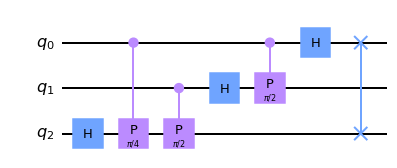

In [7]:
#TEST: QFT
#Here, we make a circuit with 3 qubits and apply the QFT to the (first) 3 qubits
qc = QuantumCircuit(3)
qft(qc, 3)
qc.draw()

In [8]:
#DEMONSTRATION: n-qubit QFT circuit (cell 1)
#Check that above code/circuit works -> encode a number in computational basis
#We will use the number 14 because this class is PHYSICS 14N :) 
bin(14) # outputs the base-10 (decimal) number 14 in binary (1110)

'0b1110'

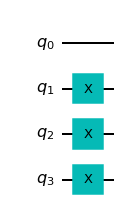

In [10]:
#DEMONSTRATION: n-qubit QFT circuit (cell 2)
#make circuit with 4 qubits, since 1110 has 4 qubits
qc = QuantumCircuit(4)
#Encode the binary number into the qubits in circuit
#Qubits 3, 2, and 1 are "1" and qubit 0 is "0" (remember the order is flipped!)
#the X gate simply flips the value, so what's originally "0" will become "1"
qc.x(1)
qc.x(2)
qc.x(3)
qc.draw()

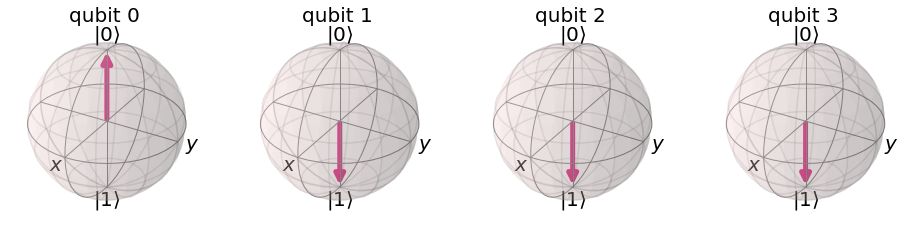

In [11]:
#DEMONSTRATION: n-qubit QFT circuit (cell 3)
#Visualize the qubit's states; we see that it matches our expectations from the previous cell for 14 before the QFT.
sv_sim = Aer.get_backend("statevector_simulator")
qobj = assemble(qc)
statevector = sv_sim.run(qobj).result().get_statevector()
plot_bloch_multivector(statevector)

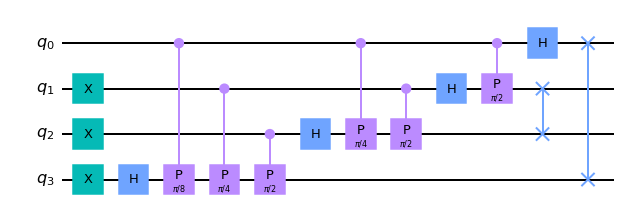

In [12]:
#DEMONSTRATION: n-qubit QFT circuit (cell 4)
#apply the QFT function on the circuit (4 qubits)
qft(qc,4)
#Visualize final state of qubits
qc.draw()

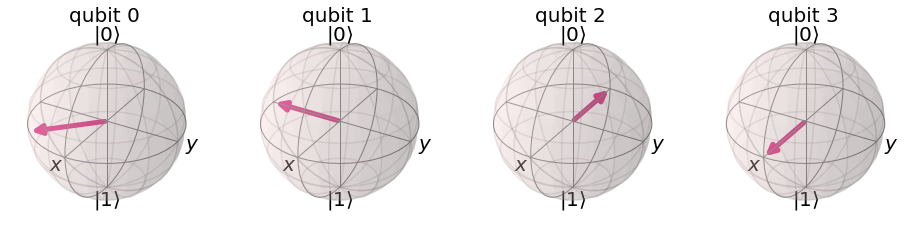

In [13]:
#DEMONSTRATION: n-qubit QFT circuit (cell 5)
#Visualize the qubit's states; we see that it matches our expectations for 14 after the QFT.
qobj = assemble(qc)
statevector = sv_sim.run(qobj).result().get_statevector()
plot_bloch_multivector(statevector)

In [14]:
#CODE/DEMO: inverse QFT 
#Run circuit from earlier on real device -> get random results (all qubits are in superposition of "0" and "1" states)
#Strategy: create the state for 14 in Fourier basis, run inverse QFT
#Then verify that the output is the expected state of 14 in the computatational basis
def inverseQft(circuit, n): #This function does inverse QFT on first n qubits in the circuit
    qftCircuit = qft(QuantumCircuit(n), n) #make QFT circuit of correct size
    inverseQftCircuit = qftCircuit.inverse() #take inverse of circuit using Qiskit's convenient inverse() function
    circuit.append(inverseQftCircuit, circuit.qubits[:n]) #add it to the first n qubits in existing circuit
    return circuit.decompose() #the .decompose() function in Qiskit lets us see individual gates

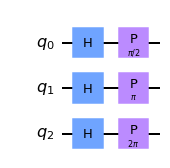

In [15]:
#DEMO: inverse QFT (cell 1)
#For the demonstration, let's choose to use the state of 2 in the Fourier basis, in a circuit of 3 qubits
numQubits = 3
numberToUse = 2
qc = QuantumCircuit(numQubits)
for qubit in range(numQubits):
    #applies Hadamard
    qc.h(qubit)
    #for the PhaseGate application, where q_i with greater i has greater theta
    qc.p(numberToUse*np.pi/(2**(numQubits-1-qubit)), qubit)
qc.draw()

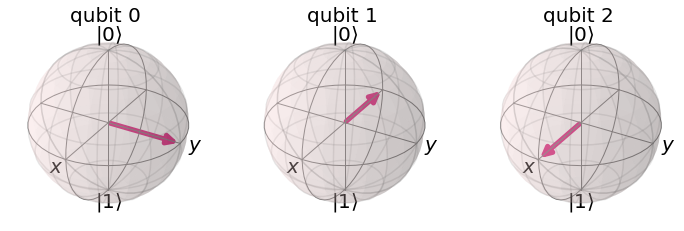

In [16]:
#DEMO: inverse QFT (cell 2)
#Visualize, confirms that we get the Fourier state 2
sv_sim = Aer.get_backend("statevector_simulator")
qobj = assemble(qc)
statevector = sv_sim.run(qobj).result().get_statevector()
plot_bloch_multivector(statevector)

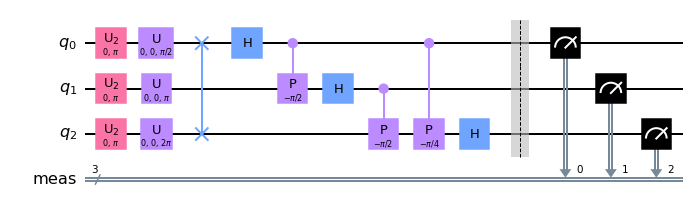

In [17]:
#DEMO: inverse QFT (cell 3)
#apply the inverse QFT on the circuit and with the number of qubits we're using
qc = inverseQft(qc,numQubits)
#Adds measurement to all qubits. Creates a new ClassicalRegister with a size equal to the number of qubits being measured.
qc.measure_all()
qc.draw()

In [18]:
#DEMO: inverse QFT (cell 4)
# Load saved IBMQ accounts + get the least busy backend device with <= numQubits
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= numQubits
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))
print("least busy backend: ", backend)

ibmqfactory.load_account:WARNING:2021-03-18 07:41:45,130: Credentials are already in use. The existing account in the session will be replaced.


least busy backend:  ibmq_lima


In [19]:
#DEMO: inverse QFT (cell 5)
shots = 2048 #shots refers to the number of repetitions of each circuit for sampling
#Transpile one or more circuits, according to some desired transpilation targets
transpiled_qc = transpile(qc, backend, optimization_level=3)
#for assembling a list of circuits or pulse schedules into a Qobj
qobj = assemble(transpiled_qc, shots=shots)
#run the job
job = backend.run(qobj)
job_monitor(job)

<ipython-input-19-7ec5a36a8833>:8: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(qobj)


Job Status: job has successfully run


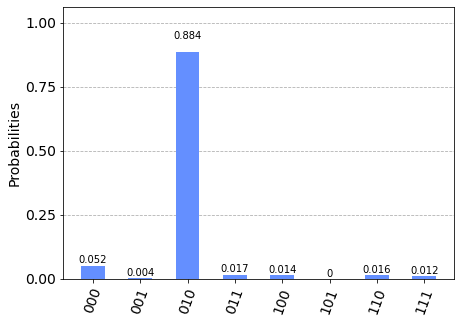

In [20]:
#DEMO: inverse QFT (cell 6)
#Now, we can plot the results of the simulation job.
counts = job.result().get_counts()
#A histogram is generated, showing percentage of simulations that generated each of the possible computational basis outcomes.
plot_histogram(counts)

In [21]:
#We see that the most probable outcome was 010.
#Indeed, the inverse QFT of 2 in the Fourier basis is 010 in the computational basis (when we're using 3 qubits)!